# Local-Linear Adaptive Segmentation with Lorentz Attractor

In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
#plotting and animation libraries
import matplotlib.pyplot as plt
import seaborn as sns
#clustering libraries
import scipy
import scipy.cluster as cl
import sklearn.cluster as skcl
import sklearn.metrics as skm
#pca library
import sklearn.decomposition as skd
import argparse
import datetime
import sys
sys.path.append('./segmentation_code/')
#My libraries
import LLSA as lvar
import LLSA_calculations as lvarc

% matplotlib inline

In [2]:
#time series from Lorentz attractor
def lorenz(x, y, z, s=10, r=28, b=2.667):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.01
T = 10000
xs = np.empty((T,3))
xs[0,:] = np.array([0., 1., 1.05])

for tt in range(T-1):
    x_dot = lorenz(xs[tt,0],xs[tt,1],xs[tt,2])
    xs[tt + 1,:] = xs[tt,:] + (x_dot * dt)

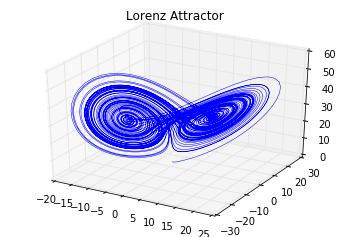

In [3]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs[:,0], xs[:,1], xs[:,2], lw=0.5)
ax.set_title("Lorenz Attractor")

In [14]:
###collecting samples
X = []
for ii in range(10):
    dt = 0.01
    T = 10000
    xs = np.empty((T,3))
    xs[0,:] = np.array([0., 1.+np.random.randn()*0.01, 1.05+np.random.randn()*0.01])

    for tt in range(T-1):
        x_dot = lorenz(xs[tt,0],xs[tt,1],xs[tt,2])
        xs[tt + 1,:] = xs[tt,:] + (x_dot * dt)
    #X.append(xs)
    X.append(ma.masked_invalid(np.array(xs,dtype=np.float64)))

# Estimate the minimum window using the condition number

The condition number of the covariance matrix of the data and the error serves as guidance for choosing the minimum window size. It tells us when the least squares regression in well-conditioned, which corresponds to a drop in the condition number (high condition numbers indicate near-singularity)

There might be situations in which the minimum window size for a well-conditioned fit is too long to capture important dynamics (relative to the correlation time). If that's the case, we recommend performing a regularization step, as detailed in the SegmentingVisAl_regularization.ipynb notebook.

In [15]:
guess_dims=5
range_minw=np.arange(guess_dims+1,6*guess_dims)
conds_x=[]
conds_cov_x=[]
n_windows_per_xx=100
for window in range_minw:
    conds=[]
    conds_cov=[]
    for xx in range(len(X)):
        tseries=X[xx]
        while len(conds)<n_windows_per_xx:
            start_t=np.random.randint(0,len(tseries))
            ts=tseries[start_t:start_t+window]
            if ma.count_masked(ts)==0 and len(ts)==window:
                conds.append(np.linalg.cond(np.cov(ts.T)))
                theta,eps=lvarc.get_theta(ts,1)
                inter,coef,cov=lvarc.decomposed_theta(theta)
                conds_cov.append(np.linalg.cond(cov)) 
    conds_x.append(np.hstack(conds))
    conds_cov_x.append(np.hstack(conds_cov))

In [16]:
def bootstrap(l,n_times,n_samples=1000,confidence_interval=95):
    if n_samples>len(l):
        n_samples=len(l)*2
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),n_samples)#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.median(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.median(l,axis=0),cil,ciu

In [17]:
median_x=[]
median_cil_x=[]
median_ciu_x=[]
median_cov_x=[]
median_cil_cov_x=[]
median_ciu_cov_x=[]
for k in range(len(conds_x)):
    median,cil,ciu=bootstrap(conds_x[k],100)
    median_x.append(median)
    median_cil_x.append(cil)
    median_ciu_x.append(ciu)
    median,cil,ciu=bootstrap(conds_cov_x[k],100)
    median_cov_x.append(median)
    median_cil_cov_x.append(cil)
    median_ciu_cov_x.append(ciu)

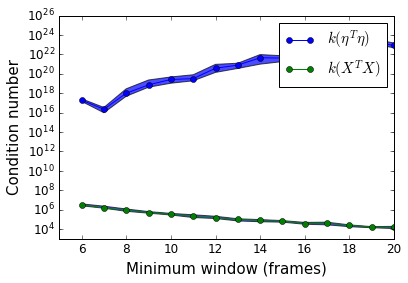

In [18]:
plt.plot(range_minw,np.hstack(median_cov_x),marker='o',label='$k(\eta^T\eta)$')
plt.fill_between(range_minw,np.hstack(median_cil_cov_x),np.hstack(median_ciu_cov_x),alpha=.7)
plt.plot(range_minw,np.hstack(median_x),marker='o',label='$k(X^TX)$')
plt.fill_between(range_minw,np.hstack(median_cil_x),np.hstack(median_ciu_x),alpha=.7)
plt.ylabel('Condition number',fontsize=15)
plt.xlabel('Minimum window (frames)',fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(guess_dims,20)
plt.legend(fontsize=15)
plt.show()

Depending on the dimensionality of the system, the condition number might drop to a larger value. As a rule of thumb, for a d-dimensional time series is it reasonable to have a condition number of order 10^d.

In [19]:
#the value of w0 should be guided by the previous plot
w0=10
step_fraction=.1
i=w0
w=[]
while i < np.inf:
    w.append(i)
    step=int(i*step_fraction)
    if int(i*step_fraction)>w0:
        break
    if step<1:
        step=1
    i+=step

# Adaptive segmentation

As discussed in the SegmentingHO.ipynb notebook, there are plenty of places along our pipeline where we can get a significant speed up by parallelizing the calculations. In this toy example, we haven't explicitly done any parallel calculation, as the nature of the parallelization will be specific to the data and the purpose of the analysis. A few examples of parallelizable parts include:

1) Likelihood ratio distribution: we need to do the exact same calculation N times

2) Parallelize over different time series, or pre-split the time series into chunks and parallelize over them

3) In the calculation of the distance matrix we can both parallelize one of the loops and also only compute the upper triangular or lower triangular matrix since, by construction, the matrix will be symmetric

In [20]:
IDX = 0
N=1000
per=97.5
sample_tseries=X[IDX]
#apply segmentation algorithm
breaks_segments=lvar.change_point(w,N,per,sample_tseries,20,cond_thresh=1e5) 
#cond_thresh is chosen in accordance to the condition number plot

In [21]:
windows_segment,segments=breaks_segments
#compute thetas in the obtained windows_segment
thetas_final=[]
for idx,seg in enumerate(segments):
    segment_windows=np.copy(windows_segment[idx])
    segments_windows=list(segment_windows)
    thetas=[]
    for seg_w in segment_windows:
        i_0,i_f=seg_w
        window_bw=sample_tseries[i_0:i_f]
        theta,eps=lvarc.get_theta(window_bw,1)
        thetas.append(np.vstack(theta))
    thetas_final.append(thetas)
thetas_final=np.concatenate(thetas_final)
windows_final=np.concatenate(windows_segment)

# Eigenvalue spectrum

In [23]:
all_eigs=[]
for theta in thetas_final:
    c,A,cov=lvarc.decomposed_theta(theta)
    coef=(A-np.identity(theta.shape[1]))*1#frameRate
    all_eigs.append(np.linalg.eigvals(coef))

### For simplicity I've used the sns kdeplot, but you can pick your favourite 2d histogram  

/Users/Macintosh/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/Macintosh/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/Macintosh/anaconda/lib/python3.5/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.red

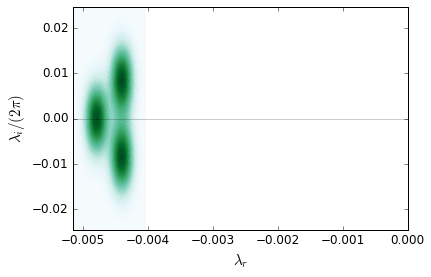

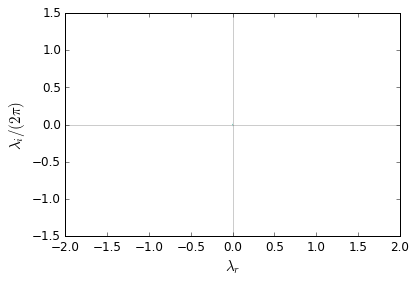

In [24]:
sns.kdeplot(np.hstack(all_eigs).real,np.hstack(all_eigs).imag/(2*np.pi),gridsize=256,shade=True,n_levels=30)
plt.axhline(0,c='k',alpha=.2)
plt.axvline(0,c='k',alpha=.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\lambda_r$',fontsize=15)
plt.ylabel('$\lambda_i/(2\pi)$',fontsize=15)
plt.show()

sns.kdeplot(np.hstack(all_eigs).real,np.hstack(all_eigs).imag/(2*np.pi),gridsize=256,shade=True,n_levels=50)
plt.axhline(0,c='k',alpha=.2)
plt.axvline(0,c='k',alpha=.2)
plt.xlim(-2,2)
plt.ylim(-1.5,1.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\lambda_r$',fontsize=15)
plt.ylabel('$\lambda_i/(2\pi)$',fontsize=15)
plt.show()

# Likelihood hierarchical clustering

In [19]:
def compute_master_theta(models,windows_w,tseries_w):
    master_tseries=[]
    for model in models:
        worm,window_idx=model
        window=windows_w[window_idx]
        t0,tf=window
        ts=tseries_w[worm][t0:tf]
        master_tseries.append(ts)
        master_tseries.append([np.nan]*ts.shape[1])
    master_tseries=ma.masked_invalid(ma.vstack(master_tseries))
    master_theta,eps=lvarc.get_theta_masked(master_tseries)
    return master_theta

def likelihood_distance(models,windows_w,tseries_w,thetas_w):
    master_theta=compute_master_theta(models,windows_w,tseries_w)
    distances=[]
    for model in models:
        worm_idx,model_idx=model
        theta=thetas_w[model_idx]
        window=windows_w[model_idx]
        t0,tf=window
        ts=ma.masked_invalid(tseries_w[worm_idx][t0:tf])
        theta_here,eps=lvarc.get_theta(ts)
        distances.append(lvarc.loglik_mvn_masked(theta,ts)-lvarc.loglik_mvn_masked(master_theta,ts))
    return np.sum(distances)

In [20]:
windows=windows_final
all_models=[]
for kw,window in enumerate(windows):
    all_models.append([worm_IDX,kw])
all_models=np.vstack(all_models)

## Compute dissimilarity matrix 

In [21]:
modelx_i=0
modelx_f=len(all_models)
modely_i=0
modely_f=len(all_models)


n_modelsx=modelx_f-modelx_i
n_modelsy=modely_f-modely_i
dissimilarity_matrix=np.zeros((n_modelsx,n_modelsy))
indices=np.array([[modelx_i,modelx_f],[modely_i,modely_f]])
for idx1,idx_model1 in enumerate(np.arange(modelx_i,modelx_f)):
    for idx2,idx_model2 in enumerate(np.arange(modely_i,modely_f)):
        model1=all_models[idx_model1]
        model2=all_models[idx_model2]
        models_=np.vstack((model1,model2))
        dist=likelihood_distance(models_,windows_final,tseries_w,thetas_final)
        dissimilarity_matrix[idx1,idx2]=dist

### Ensure symmetrization before applying Ward's method 

In [22]:
def symmetrize(a):
    return (a + a.T)/2 - np.diag(a.diagonal())

In [23]:
#this fixes possible numerical precision errors
sym_dissimilarity_matrix=symmetrize(dissimilarity_matrix)
sym_dissimilarity_matrix[sym_dissimilarity_matrix<0]=0

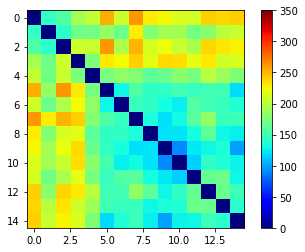

In [24]:
plt.imshow(sym_dissimilarity_matrix,cmap='jet',vmin=0,vmax=350)
plt.colorbar()
plt.show()

In [25]:
#load clustering packages
import scipy.cluster as cl
import scipy.spatial.distance as ssd

In [27]:
#turn distance matrix into a vector
pdist=ssd.squareform(sym_dissimilarity_matrix,force='tovector')
#perform hierarchical clustering using Ward's method
Z=cl.hierarchy.ward(pdist)

### Plot the dendrogram 

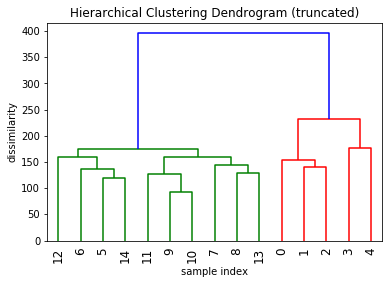

In [28]:
from scipy.cluster.hierarchy import dendrogram

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('dissimilarity')
ddgram=dendrogram(
    Z,
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.grid(False)
plt.show()

#### Organize distance matrix according to the clustering

In [29]:
import scipy.cluster.hierarchy as sch
def seriation(Z,N,cur_index):
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,Z=0,method="ward",precomputed=False):
    N = len(dist_mat)
    if precomputed:
        res_linkage = Z
    else:
        flat_dist_mat = ssd.squareform(dist_mat)
        res_linkage=sch.linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

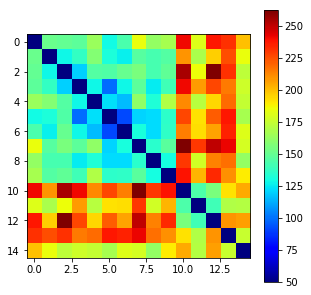

In [35]:
seriated_dist,res_order,res_linkage=compute_serial_matrix(sym_dissimilarity_matrix,Z=Z,precomputed=True)
plt.figure(figsize=(5,5))
plt.imshow(seriated_dist,cmap='jet',vmin=50)#,vmax=300)
plt.grid(False)
plt.colorbar()
plt.show()

### Num clusters as a function of dissimilarity 

In [36]:
from scipy.cluster.hierarchy import fcluster
n_clusters=[]
for max_d in np.arange(0,400,5):
    cluster_labels = fcluster(Z, max_d, criterion='distance')
    n_clusters.append(len(np.unique(cluster_labels)))

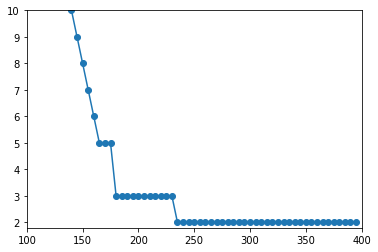

In [37]:
plt.plot(np.arange(0,400,5),n_clusters,marker='o')
plt.xlim(100,400)
plt.ylim(1.8,10)
plt.show()

### Label each model according to the clustering

In [38]:
from scipy.cluster.hierarchy import fcluster
k = 3
cluster_labels = fcluster(Z, k, criterion='maxclust')
cluster_labels

array([2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

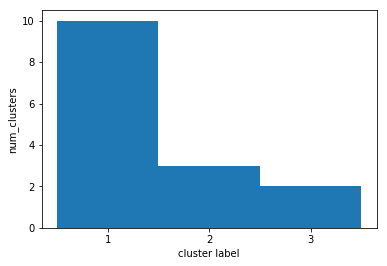

In [39]:
plt.hist(cluster_labels,range=[.5,np.max(cluster_labels)+.5],bins=np.max(cluster_labels))
plt.xticks([1,2,3])
plt.ylabel('num_clusters')
plt.xlabel('cluster label')
plt.show()

## Understanding the clusters 

In [40]:
from scipy.interpolate import CubicSpline

def unwrapma(x):
    idx= ma.array(np.arange(0,x.shape[0]),mask=x.mask)
    idxc=idx.compressed()
    xc=x.compressed()
    dd=np.diff(xc)
    ddmod=np.mod(dd+np.pi,2*np.pi)-np.pi
    ddmod[(ddmod==-np.pi)&(dd>0)]=np.pi
    phc_correct = ddmod-dd
    phc_correct[np.abs(dd)<np.pi] = 0
    ph_correct = np.zeros(x.shape)
    ph_correct[idxc[1:]] = phc_correct
    up = x + ph_correct.cumsum()
    return up

def compute_phi_omega_a3(tseries,t0,tf,frameRate=16.):
    time=np.arange(t0,tf)
    X=tseries[time]
    phi=-np.arctan2(X[:,1],X[:,0])
    cs = CubicSpline(time, phi)
    phiFilt=cs(time)
    phi_unwrap=unwrapma(phi)
    sel=~phi_unwrap.mask
    cs = CubicSpline(time[sel], phi_unwrap[sel])
    #normalize by frame rate
    phiFilt_unwrap=cs(time[sel])
    omegaFilt=cs(time[sel],1)*frameRate/(2*np.pi)
    return phiFilt,omegaFilt,X[:,2]

In [41]:
#omega is the phase velocity and it effectively measures the velocity of the body wave
#a_3 measures the turning amplitude

In [42]:
omegas_cluster=[]
a3s_cluster=[]
for idx in range(1,np.max(cluster_labels)+1):
    indices=np.arange(len(cluster_labels))[cluster_labels==idx]
    omegas=[]
    a3s=[]
    for model in all_models[indices]:
        worm,kw=model
        window=windows_final[kw]
        t0,tf=window
        tseries=tseries_w[worm]
        phi,omega,a3=compute_phi_omega_a3(tseries,t0,tf)
        omegas.append(omega)
        a3s.append(a3)
    omegas_cluster.append(np.hstack(omegas))
    a3s_cluster.append(np.hstack(a3s))

In [43]:
[np.mean(omegas) for omegas in omegas_cluster]

[0.6650234415616777, -0.91339099529375867, -0.2609563044728237]

In [44]:
[np.mean(a3s) for a3s in a3s_cluster]

[-0.0096933227032423019, 1.0476439283474495, 9.8949923698718738]

In [46]:
import seaborn as sns

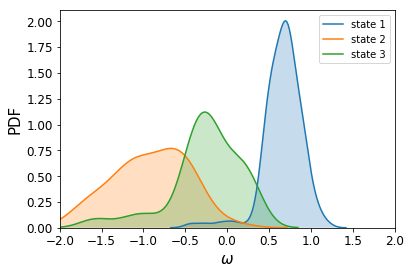

In [47]:
for idx in range(np.max(cluster_labels)):
    sns.kdeplot(omegas_cluster[idx],shade=True,label='state '+str(idx+1))
plt.xlim(-2,2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$\omega$',fontsize=15)
plt.ylabel('PDF',fontsize=15)
plt.show()

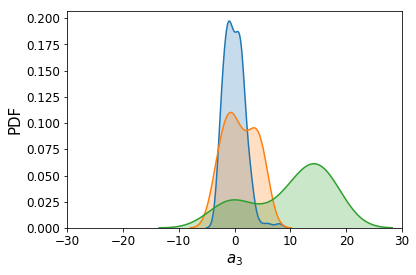

In [48]:
for idx in range(np.max(cluster_labels)):
    sns.kdeplot(a3s_cluster[idx],shade=True)
plt.xlim(-30,30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$a_3$',fontsize=15)
plt.ylabel('PDF',fontsize=15)
plt.show()

## You can also distinguish behavior by simply looking at the linear couplings and mean values 

In [49]:
def master_theta_class(models,windows_w,tseries_w):
    master_tseries=[]
    for model in models:
        worm,window_idx=model
        window=windows_w[window_idx]
        t0,tf=window
        ts=tseries_w[worm][t0:tf]
        master_tseries.append(ts)
        master_tseries.append([np.nan]*ts.shape[1])
    master_tseries=ma.masked_invalid(ma.vstack(master_tseries))
    master_theta,eps=lvarc.get_theta_masked(master_tseries)
    return master_tseries,master_theta

In [50]:
master_eigs=[]
master_thetas=[]
master_coefs=[]
for idx in range(1,np.max(cluster_labels)+1):
    indices=np.arange(len(cluster_labels))[cluster_labels==idx]
    master_tseries,master_theta_state=master_theta_class(all_models[indices],windows_final,tseries_w)
    mean=np.mean(master_tseries,axis=0)
    c,A,cov=lvarc.decomposed_theta(master_theta_state)
    coef=(A-np.identity(4))*frameRate
    eigs=np.linalg.eig(coef)[0]
    master_eigs.append(eigs)
    master_thetas.append(np.vstack((mean,coef)))
    master_coefs.append(coef)

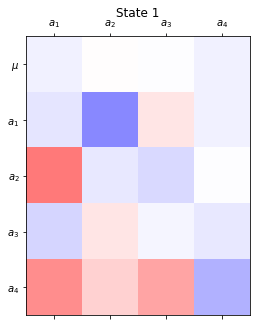

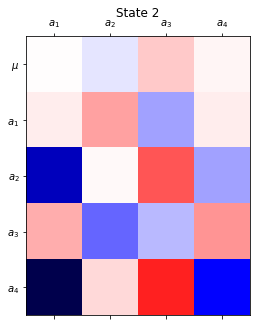

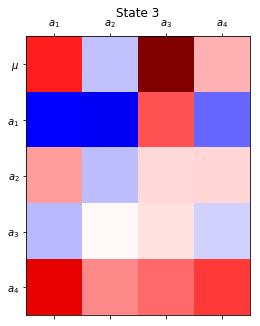

In [51]:
k=1
for theta in master_thetas:
    plt.matshow(theta,cmap='seismic',vmin=-10,vmax=10)
    plt.title('State '+str(k))
    plt.xticks(range(4),['$a_1$','$a_2$','$a_3$','$a_4$'])
    plt.yticks(range(5),['$\mu$','$a_1$','$a_2$','$a_3$','$a_4$'])
    plt.show()
    k+=1